In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import *
from tensorflow.keras.applications import ResNet50
import cv2
import numpy as np
import random
import os
import pandas as pd
import warnings

C:\Users\NITK\anaconda3\envs\Shyam_Lal\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\train",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\Valid",
    target_size=(224, 224),
    batch_size=16,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=r"D:\Akshaya\Resampled prostate images with reduced images - Copy\test",
    target_size=(224, 224),
    batch_size=16,
    shuffle=False  
)

print("Train classes:", train_generator.class_indices)
print("Validation classes:", val_generator.class_indices)
print("Test classes:", test_generator.class_indices)


Found 11684 images belonging to 4 classes.
Found 2939 images belonging to 4 classes.
Found 2854 images belonging to 4 classes.
Train classes: {'0': 0, '1': 1, '2': 2, '3': 3}
Validation classes: {'0': 0, '1': 1, '2': 2, '3': 3}
Test classes: {'0': 0, '1': 1, '2': 2, '3': 3}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D,
    Concatenate, Activation, Multiply, Reshape,
    GlobalAveragePooling2D, Dense, AveragePooling2D, Lambda, BatchNormalization
)
from tensorflow.keras.models import Model

import tensorflow as tf

def identity_block(x, filters):
    f1, f2, f3 = filters
    shortcut = x

    x = Conv2D(f1, (1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f2, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f3, (1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


def conv_block(x, filters, strides=(2,2)):
    f1, f2, f3 = filters
    shortcut = x

    x =Conv2D(f1, (1,1), strides=strides)(x)
    x =BatchNormalization()(x)
    x =ReLU()(x)
    x =Conv2D(f2, (3,3), padding='same')(x)
    x =BatchNormalization()(x)
    x =ReLU()(x)
    x =Conv2D(f3, (1,1))(x)
    x =BatchNormalization()(x)

    shortcut =Conv2D(f3, (1,1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x =ReLU()(x)
    return x

def ResNet50_Model(input_shape=(1024,1024,3), classes=4):
    inputs =Input(shape=input_shape)
    x = Conv2D(64, (7,7), strides=(2,2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = conv_block(x, [64, 64, 256], strides=(1,1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512])
    for _ in range(3):
        x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024])
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048])
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048])
        
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

resnet50_model = ResNet50_Model()
resnet50_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 512, 512, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam

resnet50_model = ResNet50_Model()

opt = Adam(learning_rate=0.0001)
resnet50_model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=5,
    verbose=1,
    cooldown=1,
    min_delta=0.0001
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

check_path = '/content/drive/MyDrive/resnetOwn D2.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    check_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

hist_scratch = resnet50_model.fit(
    train_generator,
    validation_data=val_generator, 
    epochs=30,
    verbose=1,
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/30
731/731 [==============================] - 136s 173ms/step - loss: 0.9318 - accuracy: 0.5876 - val_loss: 1.7182 - val_accuracy: 0.4740

Epoch 00001: val_loss improved from inf to 1.71823, saving model to /content/drive/MyDrive\resnetOwn D2.weights.h5
Epoch 2/30
731/731 [==============================] - 102s 140ms/step - loss: 0.7547 - accuracy: 0.6624 - val_loss: 1.4218 - val_accuracy: 0.5250

Epoch 00002: val_loss improved from 1.71823 to 1.42180, saving model to /content/drive/MyDrive\resnetOwn D2.weights.h5
Epoch 3/30
731/731 [==============================] - 102s 140ms/step - loss: 0.6937 - accuracy: 0.6948 - val_loss: 2.5072 - val_accuracy: 0.4699

Epoch 00003: val_loss did not improve from 1.42180
Epoch 4/30
731/731 [==============================] - 102s 140ms/step - loss: 0.6394 - accuracy: 0.7166 - val_loss: 0.8423 - val_accuracy: 0.6417

Epoch 00004: val_loss improved from 1.42180 to 0.84225, saving model to /content/drive/MyDrive\resnetOwn D2.weights.h5
Epoch 5/

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


Text(0, 0.5, 'Loss')

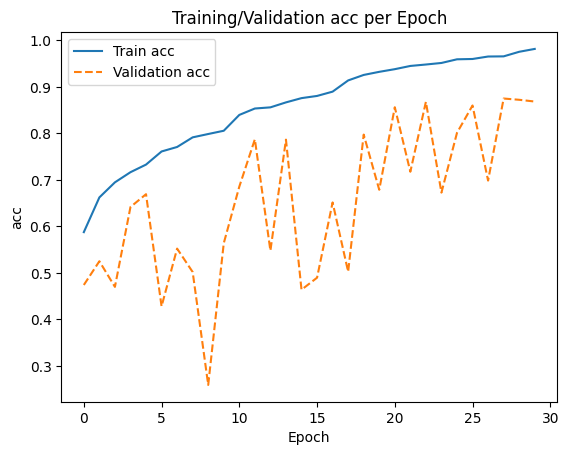

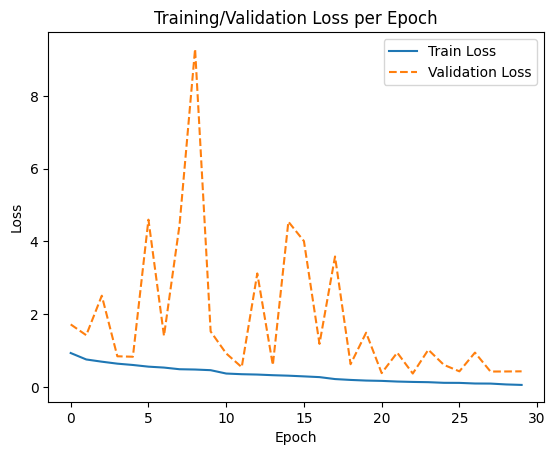

In [ ]:
print(hist_scratch.history.keys())

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['accuracy'])
ax.plot(hist_scratch.history['val_accuracy'], '--')
ax.legend(['Train acc', 'Validation acc'])
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot(hist_scratch.history['loss'], )
ax.plot(hist_scratch.history['val_loss'], '--')
ax.legend(['Train Loss', 'Validation Loss'])
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [6]:
# vgg16model.load_weights("./cropModel.h5")
class_labels = test_generator.class_indices
oriningal_test_classes = test_generator.labels
print(class_labels)
print("Original test classes")
print(oriningal_test_classes)

Y_pred =resnet50_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print("Predicted test classes")
print(y_pred)

{'0': 0, '1': 1, '2': 2, '3': 3}
Original test classes
[0 0 0 ... 3 3 3]
Predicted test classes
[0 0 0 ... 3 3 3]


In [ ]:
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=y_pred)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=y_pred,average = "macro")))
print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=y_pred)))
print('\n\n') 
cm = confusion_matrix(y_true=test_generator.labels, y_pred=y_pred)
print(cm)

Accuracy 0.8693062368605466
F1 0.8697938812127151
precision 0.870289952022145
recall 0.8694458128078817
jaccard 0.778657269959725
classification_report
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       754
           1       0.78      0.76      0.77       700
           2       0.87      0.87      0.87       700
           3       1.00      0.98      0.99       700

    accuracy                           0.87      2854
   macro avg       0.87      0.87      0.87      2854
weighted avg       0.87      0.87      0.87      2854




[[650  86  18   0]
 [100 534  66   0]
 [ 23  68 609   0]
 [  2   0  10 688]]
